# Text Classification Using the Stanford SST Sentiment Dataset
### Alexander Leung


## Introduction

In this notebook, I explore the use of tensorflow keras LSTM and Conv1D models for sentiment analysis using the Stanford SST Sentiment Dataset. The dataset consists of sentences from movie reviews that are labeled as either bearing a positive or a negative overall sentiment.

Machine Learning models that are able to accurately identify the prevailing sentiment of a given piece of text have clear utility in both commercial and policymaking realms. In the private sector, companies can use sentiment analysis as a means of better understanding how consumers view their products and services. Governments can also use sentiment analysis to determine public reception of newly instituted policies and laws. Predictive models generated from working on data like the SST dataset can hence help create value across a wide range of possible applications.

I began my model experimentation by importing the dataset (from AI Model Share) and other necessary libraries.

In [51]:
# import necessary libraries
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, Flatten, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import aimodelshare as ai
from aimodelshare.aimsonnx import model_to_onnx
from aimodelshare.aws import set_credentials
import os

In [ ]:
# install aimodelshare library
! pip install aimodelshare==0.0.189

In [2]:
# download competition data
from aimodelshare import download_data
download_data('public.ecr.aws/y2e2a1d6/sst2_competition_data-repository:latest') 


Data downloaded successfully.


In [3]:
# Set up X_train, X_test, and y_train_labels objects
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=Warning)

X_train=pd.read_csv("sst2_competition_data/X_train.csv", squeeze=True)
X_test=pd.read_csv("sst2_competition_data/X_test.csv", squeeze=True)

y_train_labels=pd.read_csv("sst2_competition_data/y_train_labels.csv", squeeze=True)

# ohe encode Y data
y_train = pd.get_dummies(y_train_labels)

# view example of X_train data
X_train.head()

0    The Rock is destined to be the 21st Century 's...
1    The gorgeously elaborate continuation of `` Th...
2    Singer/composer Bryan Adams contributes a slew...
3                 Yet the act is still charming here .
4    Whether or not you 're enlightened by any of D...
Name: text, dtype: object

## Data Preprocessing

I next preprocessed the data using keras' tokenizer function.

In [32]:
# build vocabulary from training text data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

# define preprocessor function that ensures all documents have the same length
def preprocessor(data, maxlen=40, max_words=10000):

    sequences = tokenizer.texts_to_sequences(data)

    word_index = tokenizer.word_index
    X = pad_sequences(sequences, maxlen=maxlen)

    return X

# check shape of preprocessed objects
print(preprocessor(X_train).shape)
print(preprocessor(X_test).shape)

(6920, 40)
(1821, 40)


In [15]:
# save preprocessor
ai.export_preprocessor(preprocessor,"") 

Your preprocessor is now saved to 'preprocessor.zip'


## Model 1: Simple LSTM

For my first model, I used a simple LSTM model with an embedding layer.

In [13]:
# build simple LSTM model with embedding layer
model1 = Sequential()
model1.add(Embedding(10000, 16, input_length = 40))
model1.add(LSTM(32))
model1.add(Flatten())
model1.add(Dense(2, activation = 'softmax'))

model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

history1 = model1.fit(preprocessor(X_train), y_train,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/30
173/173 [==============================] - 35s 25ms/step - loss: 0.6475 - acc: 0.6248 - val_loss: 0.7241 - val_acc: 0.4863
Epoch 2/30
173/173 [==============================] - 4s 24ms/step - loss: 0.4865 - acc: 0.7713 - val_loss: 0.9159 - val_acc: 0.5643
Epoch 3/30
173/173 [==============================] - 3s 19ms/step - loss: 0.3558 - acc: 0.8483 - val_loss: 0.5859 - val_acc: 0.7319
Epoch 4/30
173/173 [==============================] - 3s 16ms/step - loss: 0.2763 - acc: 0.8869 - val_loss: 0.4739 - val_acc: 0.7970
Epoch 5/30
173/173 [==============================] - 3s 16ms/step - loss: 0.2257 - acc: 0.9108 - val_loss: 0.6011 - val_acc: 0.7551
Epoch 6/30
173/173 [==============================] - 3s 16ms/step - loss: 0.1891 - acc: 0.9225 - val_loss: 0.6763 - val_acc: 0.7457
Epoch 7/30
173/173 [==============================] - 4s 24ms/step - loss: 0.1639 - acc: 0.9352 - val_loss: 0.6721 - val_acc: 0.7522
Epoch 8/30
173/173 [==============================] - 4s 24ms/step -

In [16]:
# save model to local onnx file
onnx_model1 = model_to_onnx(model1, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model1.onnx", "wb") as f:
    f.write(onnx_model1.SerializeToString())

I submitted this first model to a competition hosted on the AI Model Share platform.

In [17]:
#Set credentials using modelshare.org username/password    
apiurl="https://rlxjxnoql9.execute-api.us-east-1.amazonaws.com/prod/m" #This is the unique rest api that powers this specific Playground

set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [18]:
#Instantiate Competition
mycompetition= ai.Competition(apiurl)

In [19]:
# generate predicted y values from model 1
prediction_column_index1 = model1.predict(preprocessor(X_test)).argmax(axis=1)

# extract correct prediction labels 
prediction_labels1 = [y_train.columns[i] for i in prediction_column_index1]

# Submit model 1 to leaderboard
mycompetition.submit_model(model_filepath = "model1.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels1)

57/57 [==============================] - 1s 7ms/step
Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 282

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:2763


### Model 1 Performance

As can be seen from the image below, this baseline LSTM model performed decently, correctly classifying roughly 77.06% of test observations.

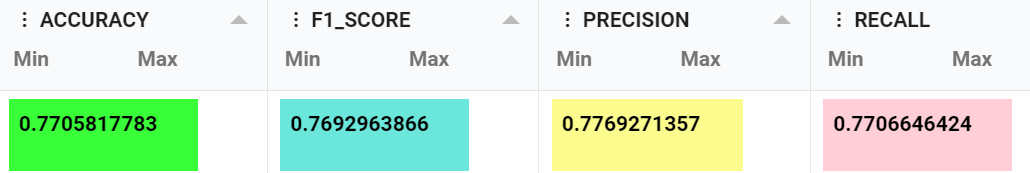

## Model 2: Conv1D

For my second model, I decided to experiment with a model that used 3 Conv1D layers. I increased the number of training epochs (from 30 to 50), and also added a callback that would reduce the model's learning rate if val_loss increased.

In [26]:
model2 = Sequential()
model2.add(layers.Embedding(10000, 16, input_length = 40))
model2.add(layers.Conv1D(32, 6, activation='relu')) 
model2.add(layers.MaxPooling1D(5))
model2.add(layers.Conv1D(32, 6, activation='relu'))
model2.add(layers.GlobalMaxPooling1D())
model2.add(layers.Dense(2, activation='softmax'))

from tensorflow.python.keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_loss',patience=3,verbose=1,factor=0.1)

model2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

history2 = model2.fit(preprocessor(X_train), y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks = red_lr)

Epoch 1/50
173/173 [==============================] - 2s 7ms/step - loss: 0.6592 - acc: 0.6149 - val_loss: 0.8567 - val_acc: 0.1488 - lr: 0.0010
Epoch 2/50
173/173 [==============================] - 1s 8ms/step - loss: 0.5265 - acc: 0.7249 - val_loss: 0.6351 - val_acc: 0.7038 - lr: 0.0010
Epoch 3/50
173/173 [==============================] - 2s 9ms/step - loss: 0.3572 - acc: 0.8457 - val_loss: 0.6532 - val_acc: 0.6994 - lr: 0.0010
Epoch 4/50
173/173 [==============================] - 2s 9ms/step - loss: 0.2611 - acc: 0.8907 - val_loss: 0.6611 - val_acc: 0.7124 - lr: 0.0010
Epoch 5/50
173/173 [==============================] - 2s 9ms/step - loss: 0.1994 - acc: 0.9212 - val_loss: 0.6047 - val_acc: 0.7493 - lr: 0.0010
Epoch 6/50
173/173 [==============================] - 2s 9ms/step - loss: 0.1499 - acc: 0.9406 - val_loss: 0.6363 - val_acc: 0.7543 - lr: 0.0010
Epoch 7/50
173/173 [==============================] - 1s 8ms/step - loss: 0.1130 - acc: 0.9581 - val_loss: 0.5949 - val_acc: 0.774

In [28]:
# save model to local onnx file
onnx_model2 = model_to_onnx(model2, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model2.onnx", "wb") as f:
    f.write(onnx_model2.SerializeToString())

In [29]:
# generate predicted y values from model2
prediction_column_index2 = model2.predict(preprocessor(X_test)).argmax(axis=1)

# extract correct prediction labels 
prediction_labels2 = [y_train.columns[i] for i in prediction_column_index2]

# Submit model2 to leaderboard
mycompetition.submit_model(model_filepath = "model2.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels2)

57/57 [==============================] - 0s 2ms/step
Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 283

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:2763


### Model 2 Performance

The more complex Conv1D model performed slightly better than the baseline LSTM model, attaining higher scores for all four of the test metrics.

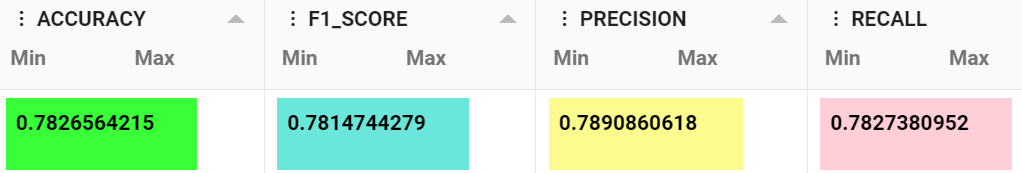

## Model 3: LSTM with Glove Embeddings

For my third model, I decided to use the same architecture as my first LSTM model, but see if model performance could be increased by using glove embeddings.

In [30]:
# Download Glove embedding matrix weights
! wget http://nlp.stanford.edu/data/wordvecs/glove.6B.zip

--2023-04-17 05:57:04--  http://nlp.stanford.edu/data/wordvecs/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/wordvecs/glove.6B.zip [following]
--2023-04-17 05:57:04--  https://nlp.stanford.edu/data/wordvecs/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/wordvecs/glove.6B.zip [following]
--2023-04-17 05:57:04--  https://downloads.cs.stanford.edu/nlp/data/wordvecs/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182753 (822M) [app

In [34]:
! unzip glove.6B.zip 

Archive:  glove.6B.zip
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       
  inflating: glove.6B.50d.txt        


In [35]:
# Extract embedding data for 100 feature embedding matrix
glove_dir = os.getcwd()

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400001 word vectors.


In [36]:
# Build embedding matrix
embedding_dim = 100

embedding_matrix = np.zeros((10000, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < 10000:
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [38]:
# reuse model 1 architecture for model 3
model3 = Sequential()
model3.add(Embedding(10000, embedding_dim, input_length = 40))
model3.add(LSTM(32))
model3.add(Flatten())
model3.add(Dense(2, activation = 'softmax'))

# use embedding matrix as weights for embedding layer
model3.layers[0].set_weights([embedding_matrix])
model3.layers[0].trainable = False

model3.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

history3 = model3.fit(preprocessor(X_train), y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/50
173/173 [==============================] - 7s 19ms/step - loss: 0.5905 - acc: 0.6783 - val_loss: 0.5431 - val_acc: 0.7688
Epoch 2/50
173/173 [==============================] - 3s 16ms/step - loss: 0.5034 - acc: 0.7464 - val_loss: 0.6103 - val_acc: 0.6857
Epoch 3/50
173/173 [==============================] - 3s 16ms/step - loss: 0.4731 - acc: 0.7701 - val_loss: 0.6404 - val_acc: 0.6532
Epoch 4/50
173/173 [==============================] - 4s 23ms/step - loss: 0.4489 - acc: 0.7812 - val_loss: 0.6907 - val_acc: 0.6236
Epoch 5/50
173/173 [==============================] - 4s 24ms/step - loss: 0.4259 - acc: 0.7980 - val_loss: 0.4895 - val_acc: 0.7796
Epoch 6/50
173/173 [==============================] - 3s 18ms/step - loss: 0.4023 - acc: 0.8120 - val_loss: 0.5572 - val_acc: 0.7363
Epoch 7/50
173/173 [==============================] - 3s 16ms/step - loss: 0.3861 - acc: 0.8201 - val_loss: 0.6995 - val_acc: 0.6705
Epoch 8/50
173/173 [==============================] - 3s 16ms/step - 

In [39]:
# save model to local onnx file
onnx_model3 = model_to_onnx(model3, framework='keras',
                          transfer_learning=True,
                          deep_learning=True)

with open("model3.onnx", "wb") as f:
    f.write(onnx_model3.SerializeToString())

In [40]:
# generate predicted y values from model3
prediction_column_index3 = model3.predict(preprocessor(X_test)).argmax(axis=1)

# extract correct prediction labels 
prediction_labels3 = [y_train.columns[i] for i in prediction_column_index3]

# Submit model2 to leaderboard
mycompetition.submit_model(model_filepath = "model3.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels3)

57/57 [==============================] - 1s 7ms/step
Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 284

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:2763


### Model 3 Performance

The third model performed better than the original LSTM model on all test metrics, and interestingly attained the same scores for all four metrics as the Conv1D model.

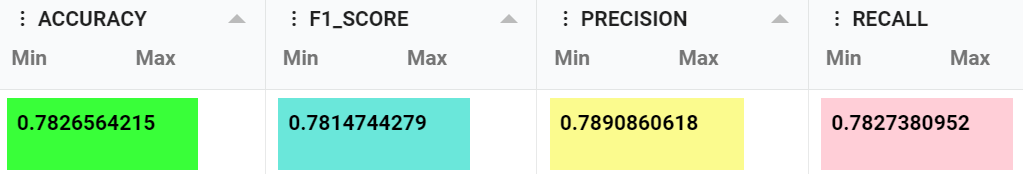

## Model 4: Conv1D with Glove Embeddings

Since the use of glove embedding weights improved the performance of my LSTM model, I decided to see if it would do the same for my second model, which used Conv1D layers.



In [46]:
# reuse model 2 architecture for model 4
model4 = Sequential()
model4.add(layers.Embedding(10000, embedding_dim, input_length = 40))
model4.add(layers.Conv1D(32, 6, activation='relu')) 
model4.add(layers.MaxPooling1D(5))
model4.add(layers.Conv1D(32, 6, activation='relu'))
model4.add(layers.GlobalMaxPooling1D())
model4.add(layers.Dense(2, activation='softmax'))

# use embedding matrix as weights for embedding layer
model4.layers[0].set_weights([embedding_matrix])
model4.layers[0].trainable = False

model4.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

history4 = model4.fit(preprocessor(X_train), y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks = red_lr)

Epoch 1/50
173/173 [==============================] - 10s 22ms/step - loss: 0.6169 - acc: 0.6499 - val_loss: 0.7236 - val_acc: 0.5600 - lr: 0.0010
Epoch 2/50
173/173 [==============================] - 3s 17ms/step - loss: 0.4995 - acc: 0.7560 - val_loss: 0.7614 - val_acc: 0.6091 - lr: 0.0010
Epoch 3/50
173/173 [==============================] - 3s 17ms/step - loss: 0.4329 - acc: 0.7982 - val_loss: 0.7520 - val_acc: 0.6207 - lr: 0.0010
Epoch 4/50
173/173 [==============================] - 3s 20ms/step - loss: 0.3705 - acc: 0.8300 - val_loss: 0.7220 - val_acc: 0.6691 - lr: 0.0010
Epoch 5/50
173/173 [==============================] - 3s 19ms/step - loss: 0.3147 - acc: 0.8645 - val_loss: 1.0530 - val_acc: 0.5527 - lr: 0.0010
Epoch 6/50
173/173 [==============================] - 3s 16ms/step - loss: 0.2581 - acc: 0.8936 - val_loss: 0.5814 - val_acc: 0.7529 - lr: 0.0010
Epoch 7/50
173/173 [==============================] - 3s 15ms/step - loss: 0.2124 - acc: 0.9155 - val_loss: 0.4271 - val_ac

In [47]:
# save model to local onnx file
onnx_model4 = model_to_onnx(model4, framework='keras',
                          transfer_learning=True,
                          deep_learning=True)

with open("model4.onnx", "wb") as f:
    f.write(onnx_model4.SerializeToString())

In [48]:
# generate predicted y values from model4
prediction_column_index4 = model4.predict(preprocessor(X_test)).argmax(axis=1)

# extract correct prediction labels 
prediction_labels4 = [y_train.columns[i] for i in prediction_column_index4]

# Submit model2 to leaderboard
mycompetition.submit_model(model_filepath = "model4.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels4)

57/57 [==============================] - 0s 3ms/step
Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 286

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:2763


### Model 4 Performance

Interestingly, the Conv1D model performed worse when glove embeddings were used. This does not necessarily suggest that a glove embeddings will not improve the performance of a Conv1D model on this dataset; it may be the case that the model overfit to training data (notice that the learning rate was reduced repeatedly by the callback function during model training), hence, starting with a lower base training rate might have improved performance.

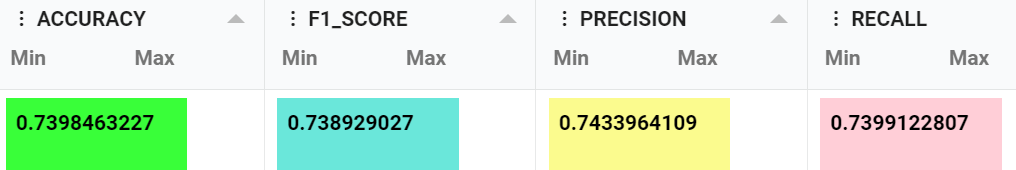

## Model 5: Stacked LSTM with Glove Embeddings

I next decided to try to improve on the performance of my LSTM model with glove embeddings by stacking 3 LSTM layers instead of only using 1.

In [50]:
# instantiate model
model5 = Sequential()
model5.add(Embedding(10000, embedding_dim, input_length = 40))
model5.add(LSTM(32, return_sequences=True))
model5.add(LSTM(32, return_sequences=True))
model5.add(LSTM(32, return_sequences=True))
model5.add(LSTM(32))
model5.add(Flatten())
model5.add(Dense(2, activation = 'softmax'))

# use embedding matrix as weights for embedding layer
model5.layers[0].set_weights([embedding_matrix])
model5.layers[0].trainable = False

model5.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

history5 = model5.fit(preprocessor(X_train), y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks = red_lr)

Epoch 1/50
173/173 [==============================] - 28s 105ms/step - loss: 0.6199 - acc: 0.6584 - val_loss: 0.9413 - val_acc: 0.3931 - lr: 0.0010
Epoch 2/50
173/173 [==============================] - 12s 68ms/step - loss: 0.5501 - acc: 0.7189 - val_loss: 0.5825 - val_acc: 0.7074 - lr: 0.0010
Epoch 3/50
173/173 [==============================] - 12s 71ms/step - loss: 0.5041 - acc: 0.7448 - val_loss: 0.6995 - val_acc: 0.6727 - lr: 0.0010
Epoch 4/50
173/173 [==============================] - 15s 87ms/step - loss: 0.4734 - acc: 0.7738 - val_loss: 0.6154 - val_acc: 0.7233 - lr: 0.0010
Epoch 5/50
173/173 [==============================] - 11s 64ms/step - loss: 0.4389 - acc: 0.7908 - val_loss: 0.5402 - val_acc: 0.7233 - lr: 0.0010
Epoch 6/50
173/173 [==============================] - 12s 69ms/step - loss: 0.4167 - acc: 0.8009 - val_loss: 0.5761 - val_acc: 0.7579 - lr: 0.0010
Epoch 7/50
173/173 [==============================] - 14s 79ms/step - loss: 0.3951 - acc: 0.8100 - val_loss: 0.4273 -

In [52]:
# save model to local onnx file
onnx_model5 = model_to_onnx(model5, framework='keras',
                          transfer_learning=True,
                          deep_learning=True)

with open("model5.onnx", "wb") as f:
    f.write(onnx_model5.SerializeToString())

In [53]:
# generate predicted y values from model5
prediction_column_index5 = model5.predict(preprocessor(X_test)).argmax(axis=1)

# extract correct prediction labels 
prediction_labels5 = [y_train.columns[i] for i in prediction_column_index5]

# Submit model2 to leaderboard
mycompetition.submit_model(model_filepath = "model5.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels5)

57/57 [==============================] - 3s 22ms/step
Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 287

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:2763


## Model 5 Performance

The model performed better than the baseline LSTM model with glove embeddings, however, this improvement was very slight. Model 5 performed nominally better than the baseline model on accuracy, f1, and recall scores, but did marginally worse than the baseline model on precision.

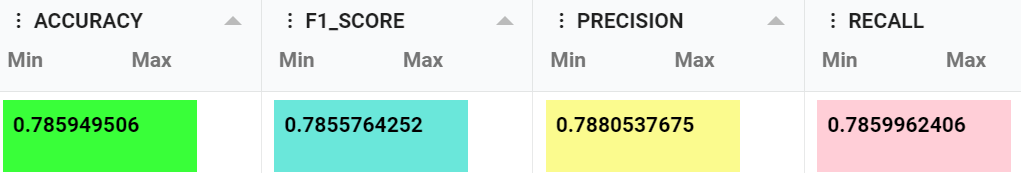

## Model 6: Bidirectional Stacked LSTMS with Glove Embeddings and Dropouts

For my 6th and final model, I decided to test if wrapping the stacked LSTM layers in a Bidrectional() call would further improve model performance. I also used dropouts in the LSTM layers.

In [54]:
# instantiate model
model6 = Sequential()
model6.add(Embedding(10000, embedding_dim, input_length = 40))
model6.add(Bidirectional(LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
model6.add(Bidirectional(LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
model6.add(Bidirectional(LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
model6.add(Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2)))
model6.add(Flatten())
model6.add(Dense(2, activation = 'softmax'))

# use embedding matrix as weights for embedding layer
model6.layers[0].set_weights([embedding_matrix])
model6.layers[0].trainable = False

model6.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

history6 = model6.fit(preprocessor(X_train), y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks = red_lr)

Epoch 1/50
173/173 [==============================] - 77s 334ms/step - loss: 0.5939 - acc: 0.6725 - val_loss: 0.9011 - val_acc: 0.4877 - lr: 0.0010
Epoch 2/50
173/173 [==============================] - 57s 328ms/step - loss: 0.5201 - acc: 0.7330 - val_loss: 0.5559 - val_acc: 0.7305 - lr: 0.0010
Epoch 3/50
173/173 [==============================] - 57s 329ms/step - loss: 0.4846 - acc: 0.7614 - val_loss: 0.7602 - val_acc: 0.5195 - lr: 0.0010
Epoch 4/50
173/173 [==============================] - 57s 329ms/step - loss: 0.4676 - acc: 0.7728 - val_loss: 0.7961 - val_acc: 0.6647 - lr: 0.0010
Epoch 5/50
173/173 [==============================] - 56s 323ms/step - loss: 0.4482 - acc: 0.7820 - val_loss: 0.3809 - val_acc: 0.8613 - lr: 0.0010
Epoch 6/50
173/173 [==============================] - 57s 329ms/step - loss: 0.4388 - acc: 0.7908 - val_loss: 0.4252 - val_acc: 0.8100 - lr: 0.0010
Epoch 7/50
173/173 [==============================] - 56s 324ms/step - loss: 0.4199 - acc: 0.8024 - val_loss: 0.

In [55]:
# save model to local onnx file
onnx_model6 = model_to_onnx(model6, framework='keras',
                          transfer_learning=True,
                          deep_learning=True)

with open("model6.onnx", "wb") as f:
    f.write(onnx_model6.SerializeToString())

In [56]:
from google.colab import files
files.download('model6.onnx') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [57]:
# generate predicted y values from model6
prediction_column_index6 = model6.predict(preprocessor(X_test)).argmax(axis=1)

# extract correct prediction labels 
prediction_labels6 = [y_train.columns[i] for i in prediction_column_index6]

# Submit model2 to leaderboard
mycompetition.submit_model(model_filepath = "model6.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels6)

57/57 [==============================] - 5s 46ms/step
Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 288

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:2763


### Model 6 Performance

As can be seen from the image below, wrapping the LSTM layers in Bidirectional() calls and implementing dropouts did indeed improve model performance - although only marginally. Considering that this model took substantially more time to train than the stacked LSTM model with glove embeddings, the added value of the bidirectional model and dropouts is debatable.

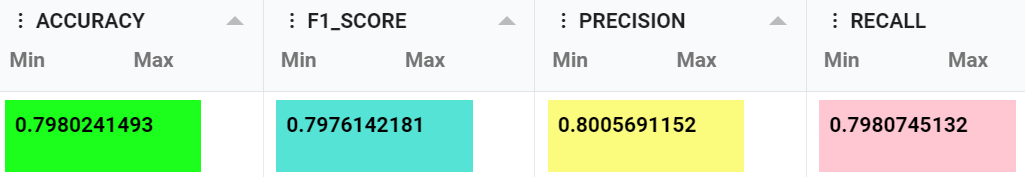

## Conclusion

In this notebook I explored how LSTM and Conv1D models could be used to conduct sentiment analysis on the classic Stanford SST dataset. While my most complex model (bidirectional stacked LSTM with dropout and glove embeddings) performed the best, it provided only a marginal improvement over a simple baseline model with only one LSTM layer, and which did not use pre-trained embedding weights. Interestingly, the use of glove embeddings did not appear to improve the performance of a Conv1D model, though this could potentialy be attributed to model overfitting. To further improve model performance in further experimentation, more granular hyperparameter tuning could be explored.